# Loss Functions

When fitting data to labels we need to measure the degree of goodness of fit. This sounds obvious but isn't quite so straightforward. In fact, there are entire fields of statistics that focus solely on that (e.g. robust statistics). In this notebook we'll discuss a number of ways how we can measure whether our model is doing well. As a side-benefit, we'll get to know the loss function layers in ``gluon``. We begin with our default import ritual.

In [1]:
import mxnet as mx
import mxnet.gluon as gluon
from mxnet import nd, autograd
import matplotlib.pyplot as plt
import numpy as np
import mxnet.autograd as ag
mx.random.seed(1)

## Regression - L1 loss

As we discussed in the introduction, regression describes the cases where we want to estimate some real valued number $f(x) \in \mathbb{R}$ to match an observation $y$. A natural idea of measuring the distance would be to compute $|y - f(x)|$. This makes sense, e.g. if we need to estimate how much it might cost to manufacture a product: if we estimate too low, we will incur a loss due to underestimation. If we overprice it, we will sell fewer products (here we're making the unrealistic assumption that both are equally bad). In math, the loss function is

$$l(y,f) = |y-f|$$

Let's compute it with ``gluon`` and also its gradient. 

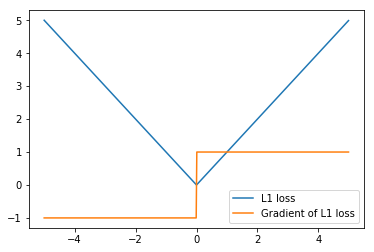

In [2]:
loss = gluon.loss.L1Loss()

# getting data ready
output = nd.arange(-5,5,0.01)
output.attach_grad() # we need the gradient
thelabel = nd.zeros(shape=(output.size)) 
with ag.record():    # start recording
    theloss = loss(output, thelabel)
theloss.backward()   # and compute the gradient

plt.plot(output.asnumpy(), theloss.asnumpy(), label='L1 loss')
plt.plot(output.asnumpy(), output.grad.asnumpy(), label='Gradient of L1 loss')
plt.legend()
plt.show()

Before we move on to other losses, let's quickly consider what happens if we want to minimize the L1 loss. Consider the toy example where we have a number of labels $y_i$ and we want to fit *all* of them to a single scalar, say $f$. In this case we need to solve the minimization problem:

$$\mathop{\mathrm{minimize}}_f \sum_i |y_i - f|$$

As we saw above, the gradient is either -1 or 1. Hence, for the gradients to the left and to the right of $f$ to cancel out we need *the same number of $y_i$* on either side. This is the definition of the *median*. Hence, minimizing the L1 loss means that we are computing the median (at least for constant predictions). In general, the L1 loss is very robust against outliers, since the gradients can never get too large. 

## Regression - L2 loss

Taking the squared distance between observation and estimate tends to be the default choice in many problems. Often for convenience we multiply this loss by a factor of $\frac{1}{2}$ to ensure that the derivatives look pretty. Here's the loss:

$$l(y,f) = \frac{1}{2} (y-f)^2$$

For vectorial $f$ and $y$ this is the squared Euclidean distance between points. The L2 loss has a few other nice properties. By a similar argument as before we can see that $\sum_{i=1}^m \frac{1}{2} (y_i - f)^2$ is minimized by choosing $f = \frac{1}{m} \sum_{i=1}^m y_i$, i.e. by choosing the mean. Let's see what it looks like in practice.

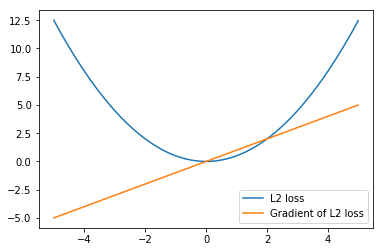

In [3]:
loss = gluon.loss.L2Loss()

with ag.record():    # start recording
    theloss = loss(output, thelabel)
theloss.backward()   # and compute the gradient

plt.plot(output.asnumpy(), theloss.asnumpy(), label='L2 loss')
plt.plot(output.asnumpy(), output.grad.asnumpy(), label='Gradient of L2 loss')
plt.legend()
plt.show()

## Regression - Huber's Robust loss

Huber's Robust Loss is a cross between the L1 and the L2 loss. It behaves like an L2 loss close to zero. Beyond that, for discrepancies larger than $\rho$ it behaves like an L1 loss. The scaling is set up in such a way as to ensure that the derivative is continuous. 

$$l(y,f) = \begin{cases}
\frac{1}{2 \rho} (y-f)^2 & \text{ for } |y-f| < \rho \\
|y-f| - \frac{\rho}{2} & \text{ otherwise}
\end{cases}$$

If we minimize the loss something interesting happens (again, we're in the toy scenario that we just estimate a scalar). The number of cases with $y_i < f-\rho$ and with $y_i > f+\rho$ are going to cancel out, since their gradients are all $-1$ and $1$ respectively. For all the $y_i$ closer to $f$, the gradients will balance out like in the L2 loss case. In other words, $f$ will be the mean for all points closer than $\rho$. This is pretty much what a *trimmed mean* estimator does. It ensures that a few outliers (very large $|y_i|$) won't break the estimate. Let's check it out in practice.

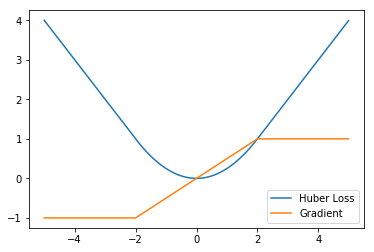

In [13]:
def huber(f,y):
    rho = 2
    loss = nd.abs(f-y)
    loss = (loss > rho) * (loss - rho/2) + (0.5/rho) * (loss <= rho) * loss**2
    return loss

loss = huber
with ag.record():    # start recording
    theloss = loss(output, nd.zeros_like(output))
theloss.backward()   # and compute the gradient

plt.plot(output.asnumpy(), theloss.asnumpy(), label='Huber Loss')
plt.plot(output.asnumpy(), output.grad.asnumpy(), label='Gradient')
plt.legend()
plt.show()

## Classification - Logistic Regression

Next consider the case where we have two labels, say ``cat`` and ``dog``. Since statisticians (and computers) don't like strings, we simplify this to $y \in \{\pm 1\}$. One way of mapping real numbers in $\mathbb{R}$ into class probabilities is to use a sigmoid function.

$$p(y|f) = \frac{1}{1 + \exp(-y f)} \text{ and hence } -\log p(y|f) = \log(1 + \exp(-y f))$$

*Side remark for math nerds:* To keep the term numerically stable we can rewrite it as $-yf + \log(1 + \exp(yf))$ whenever $yf < 0$. The reason for doing this is to avoid exponentiating a large positive number which would trigger a numerical overflow.  Combining both expressions we get the following expression: $\log(1 + \exp(-|yf|)) - \delta(yf < 0) \cdot yf$. 

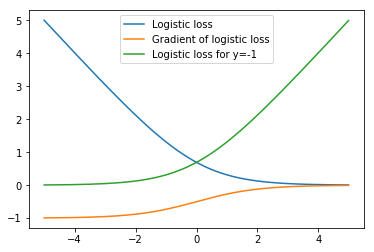

In [4]:
def loss(f,y):
    return -nd.log(nd.LogisticRegressionOutput(f*y, nd.ones_like(f)))

# getting data ready
thelabel = nd.ones_like(output)
with ag.record():    # start recording
    theloss = loss(output, thelabel)
theloss.backward()   # and compute the gradient

plt.plot(output.asnumpy(), theloss.asnumpy(), label='Logistic loss')
plt.plot(output.asnumpy(), output.grad.asnumpy(), label='Gradient of logistic loss')
# now compute the loss for y=-1
theloss = loss(output, -thelabel)
plt.plot(output.asnumpy(), theloss.asnumpy(), label='Logistic loss for y=-1')
plt.legend()
plt.show()

As we can see, the loss function asymptotes the negative identity function for very negative values of $yf$. For very large positive values of $yf$, the loss converges to 0. This is desirable, since large values of $yf$ mean that the classification is correct. 

## Classification - Multiclass Softmax

One way of dealing with multiple classes is to turn it into $n$ binary classification problems. That is, we simply test: 'is it class 1', 'is it class 2', ... 'is it class n'. In theory this sounds like a splendid idea. After all, this should be just as easy as determining which class it is. Unfortunately, that's not quite the case. Imagine the situation where none of the $n$ classifiers wants to take responsibility. Or imagine the case where more than one claims that it's his turn. Obviously there has to be a better way. Indeed, there is.

If we have a vector $f \in \mathbb{R}^n$ of scores, where the coordinate, say $f_i$ is large whenever we think that the correct class is $i$, then we can map $f$ into a probability vector via

$$p(y=i|f) \propto \exp(f_i) \text{ and hence } p(y=i|f) = \frac{\exp(f_i)}{\sum_j \exp(f_j)}$$

Here the normalization by $\sum_j \exp(f_j)$ is needed such that all the terms sum up to 1. Consequently the negative log-likelihood $-\log p(y|f)$, i.e. the quantity that we would want to minimize in this case is given by 

$$-\log p(y=i|f) = \log \left[\sum_{j} \exp(f_j)\right] - f_i$$

In ``gluon`` the relevant function is [mxnet.gluon.loss.SoftmaxCrossEntropyLoss](http://mxnet.io/api/python/gluon.html#mxnet.gluon.loss.SoftmaxCrossEntropyLoss). Let's check that this is correct.

In [5]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()

f = nd.random_normal(shape=(1,10))
y = nd.array([4]) #class 4 is true

print('Softmax loss is {}.'.format(loss(f,y).asscalar()))

# now compute this by hand

p = nd.exp(f)
p = p / nd.sum(p)
print('Class 4 has negative log-likelihood {}.'.format(-nd.log(p[0,4]).asscalar()))

Softmax loss is 1.5590695142745972.
Class 4 has negative log-likelihood 1.5590696334838867.


The softmax loss has a rather nice property that is worth pointing out: its gradient is given by the difference between the conditional class probabilities $p(y=i|f)$ and the indicator vector $e_j$. This can be derived via 

$$\partial_{f_i} \log \sum_j \exp(f_j) = \frac{\exp(f_i)}{\sum_j \exp(f_j)} = p(y=i|f)$$

Such a result seems to be too good to be true by chance. In fact, it holds for *every* member of a larger family of distributions, called the [Exponential Family](https://en.wikipedia.org/wiki/Exponential_family). More specifically, the derivative of the associated normalization is the expected value of the associated embedding. 

## Classification - Soft Margin Loss

Note that the logistic loss isn't the only loss that one might encounter. For instance, in Support Vector Machines we have a soft-margin loss. It is $0$ whenever data is correctly classified with some confidence, say $y f(x) > 1$. Otherwise we impose a linear penalty. In math this amounts to

$$l(y,f) = \mathrm{max}(0, 1- yf)$$

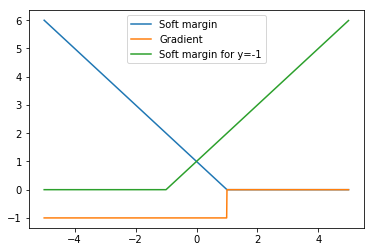

In [9]:
def softmargin(f,y):
    loss = 1.0 - y * f
    return loss * (loss > 0)

loss = softmargin
with ag.record():    # start recording
    theloss = loss(output, thelabel)
theloss.backward()   # and compute the gradient

plt.plot(output.asnumpy(), theloss.asnumpy(), label='Soft margin')
plt.plot(output.asnumpy(), output.grad.asnumpy(), label='Gradient')
# now compute the loss for y=-1
theloss = loss(output, -thelabel)
plt.plot(output.asnumpy(), theloss.asnumpy(), label='Soft margin for y=-1')
plt.legend()
plt.show()


## Entropy

Sometimes we care about probabilities rather than just labels. In particular, we might want to measure the distance between distributions. For that we need some basics about probabilities, such as the [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)). In a nutshell, the entropy of a random variable is the amount of surprise we encounter each time we sample from it. For instance, the entropy of the constant function is zero, since we already know what's coming. The entropy of a fair coin being tossed is 1 bit. We have no idea what's going to happen (it's a fair coin after all) and there are only two possible outcomes. If we had a biased coin, e.g. one that produces heads with probability 0.9 and tails with probability 0.1, the surprise would be less (after all, most of the time we see a head). Correspondingly its entropy should be lower. On the other hand, a dice with 6 possible outcomes should have a higher degree of surprise. Without further ado, let's define the entropy function:

$$H[p] := \sum_x -p(x) \log p(x)$$

This works well for discrete outcomes. For densities we use

$$H[p] := \int -p(x) \log p(x) dx$$

We can check that for a fair coin the entropy is given by $H[p] = -2 \cdot 0.5 \log 0.5 = \log 2$. Information theorists often measure the information in 'nats' rather than bits. The difference is the base of the logarithm. It's easy to convert: 1 nat is $\log_2 e \approx 1.44$ bit. More generally, for a uniform distribution over $N$ outcomes it is $H[p] = \log N$. One of the fundamental theorems in information theory is that for a distribution $p$, we need at least $H[p]$ nats to encode it. 

There are a number of useful properties for the entropy that are employed in machine learning: 

* Often when estimating distributions we want to find the one with the largest entropy that fits the requirements. That's in line with our desire to restrict our estimates as little as possible beyond what we actually observe.
* The entropy is a concave function. That is, for two distributions $p$ and $q$, the mixture of both has higher entropy: $H[\lambda p + (1-\lambda) q] \geq \lambda H[p] + (1-\lambda) H[q]$. To prove this, simply note that the function $-x \log x$ is concave. 
* When we have independent random variables, say $x$ and $y$, then the entropy of the joint distribution is the sum of the individual entropies. This follows simply from the fact that $\log p(x) q(y) = \log p(x) + \log q(y)$. 
* For dependent random variables the joint entropy is lower than that of the individual terms. This can be seen as follows:

$$\begin{eqnarray}
H[p(x,y)] = & \int -p(x,y) \log p(x,y) \\
= & \int -p(x,y) [\log p(x) p(y)] dx dy + \int p(x,y) \log \frac{p(x) p(y)}{p(x,y)} dx dy \\
\leq & H[p(x)] + H[p(y)] + \log \int p(x,y) \frac{p(x) p(y)}{p(x,y)} dx dy \\
= & H[p(x)] + H[p(y)]
\end{eqnarray}$$

Here the inequality follows from the fact that $\log x$ is a concave function, hence the expectation of the logarithm is less than the logarithm of the expectation. Intuitively this result is straightforward - if $x$ and $y$ are dependent on each other, then knowing $x$ should tell us some more about $y$. Therefore, the joint entropy of $x$ and $y$ should be lower than the sum of the individual entropies. 

This leads us to the notion of mutual information. It is given by the difference between joint and and independent entropies, i.e. $I(x,y) := H[p(x)] + H[p(y)] - H[p(x,y)]$. Basically it's the amount of information that we save. For instance, a light switch and a (functioning) light bulb are strongly correlated - knowing one tells us all about the other. The entropy of the joint is 1 bit (if it's on with probability 0.5), but the sum of the entropies of switch and bulb individually is 2 bit. Hence the mutual information is 1 bit. 

## Kullback Leibler Divergence

This brings us to the KL divergence. It measures how close two distributions are. One way of defining such a quantity is to ask how many extra bits one would have to spend to encode data drawn from $p$ when using a code tuned for $q$. If we assume for a fact that it takes $-\log p(x)$ nat to optimally encode $x$, then the penalty from using the 'wrong' code is given by 

$$D(p\|q) = \sum_x p(x) [\log p(x) - \log q(x)]$$

For densities the quantity is defined analogously, i.e. $\int p(x) [\log p(x) - \log q(x)] dx$. The first thing to prove is that this is actually a distance. For that we need to show that $D(p\|q) \geq 0$ with equality only for $p=q$. To see the latter, simply plug $p=q$ into the definition. To see the former, we rewrite $D$ in the same way as above, using convexity, this time of $-\log x$. 

$$D(p\|q) = \sum_x -p(x) \log \frac{q(x)}{p(x)} \geq -\log \sum_x p(x) \frac{q(x)}{p(x)} = 0$$

As an aside, to see that $H[p]$ can be achieved, indeed, quantize all $p(x)$ into bins of the next largest fraction of $2$, e.g. $0.2$ goes into the bin of $\frac{1}{4}$. It is clear that the sum over those bins is no smaller than $1$ and no larger than $2$. Moreover, we can arrange them into a tree, where at level $l$ the bins are of size $2^{1-l}$. Then we simply index these bins according to their position of the tree. Each $x$ will require $\lceil \log_2 p(x) \rceil$ bits (whatever is left over, we simply discard). In sum this is no more than $\log_2 H[p] + 1$. To tighten the bound, simply send $N$ symbols. Since they can be encoded using at most $N \log_2 H[p] + 1$ bit, the code becomes increasingly efficient with only $1/N$ waste. This proves that such a code can be found. That it's impossible to do any better is a consequence of $D(p\|q) \geq 0$.  
Note that our construction relied on very long codes for efficiency. This is a real problem in practice. [Turbo codes (https://en.wikipedia.org/wiki/Turbo_code) are one of the techniques to address this, e.g. for mobile communications. 

After this long detour, let's finally get to the KL divergence as a loss function. It generalizes the multiclass softmax as follows: instead of having just a single possible true class, it uses a probability distribution as reference. That is

$$\log(f,y) = \sum_i y_i (log(y_i) - f_i)$$

Here $f_i$ is assume to be a probability distribution (or we can set a flag to transform the output into one beforehand). 

In [7]:
loss = gluon.loss.KLDivLoss()

# generate some random probability distribution
f = nd.random_normal(shape=(1,10))
p = nd.exp(f)
p = p / nd.sum(p)

# generate some target distribution
y = nd.random_normal(shape=(1,10))
y = nd.exp(y)
y = y / nd.sum(y)

z = nd.zeros_like(y)
z[0,3] = 1

# distance between our estimate p and the 'true' distribution y
print(loss(nd.log(p), y))
# distance to itself - should be zero
print(loss(nd.log(p), p))
# equivalent of logistic loss with class 3 up to normalization over domain, i.e. 1/10
# note that this is VERY DIFFERENT from information theory but a traditional choice
# in deep learning
print(loss(nd.log(p), z))
print(-nd.log(p[0,3]))


[ 0.03703964]
<NDArray 1 @cpu(0)>

[  7.81620457e-09]
<NDArray 1 @cpu(0)>

[ 0.16921173]
<NDArray 1 @cpu(0)>

[ 1.69211733]
<NDArray 1 @cpu(0)>
